## Importing Data

In [1]:
import pandas as pd

orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')


## Data Cleaning & Transformation 

In [2]:
# Convert to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Merge data
merged_df = orders.merge(order_items, on='order_id')
merged_df = merged_df.merge(payments, on='order_id')

# Create new columns
merged_df['delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days
merged_df['delay'] = (merged_df['order_delivered_customer_date'] - merged_df['order_estimated_delivery_date']).dt.days


## Exploratory Data Analysis (EDA)

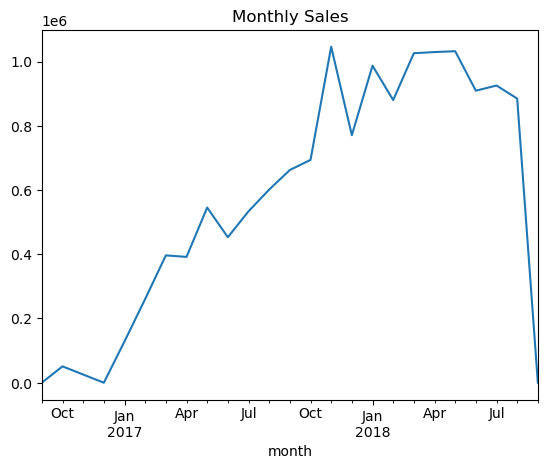

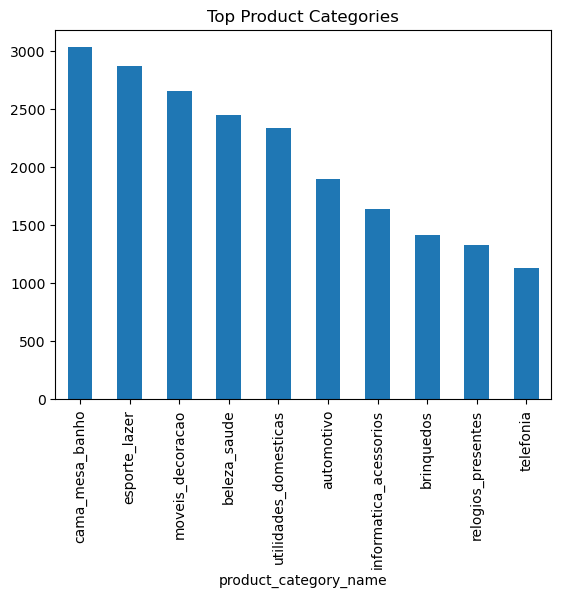

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Monthly sales trend
merged_df['month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = merged_df.groupby('month')['price'].sum()
monthly_sales.plot(kind='line', title='Monthly Sales')
plt.show()

# Top categories
top_categories = products['product_category_name'].value_counts().head(10)
top_categories.plot(kind='bar', title='Top Product Categories')
plt.show()

## Customer Segmentation (RFM Analysis)

In [4]:
# First: Merge payments with orders to get customer_id
payments_with_customers = payments.merge(orders[['order_id', 'customer_id']], on='order_id')

# Then: Aggregate Monetary value by customer_id
monetary_df = payments_with_customers.groupby('customer_id')['payment_value'].sum().reset_index()

# Prepare RFM table
from datetime import datetime

now = datetime(2018, 9, 1)

rfm_df = orders.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (now - x.max()).days,
    'order_id': 'count'
}).rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency'
}).reset_index()

# Merge Monetary
rfm_df = rfm_df.merge(monetary_df.rename(columns={'payment_value': 'Monetary'}), on='customer_id')

# Scoring
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1])
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4])
rfm_df['RFM_Score'] = rfm_df[['R_score', 'F_score', 'M_score']].sum(axis=1)

rfm_df.head()


,customer_id,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,00012a2ce6f8dcda20d059ce98491703,290,1,114.74,2,1,3,6
1,000161a058600d5901f007fab4c27140,411,1,67.41,1,1,2,4
2,0001fd6190edaaf884bcaf3d49edf079,549,1,195.42,1,1,4,6
3,0002414f95344307404f0ace7a26f1d5,380,1,179.35,1,1,4,6
4,000379cdec625522490c315e70c7a9fb,151,1,107.01,3,1,3,7


## Sales Forecasting (Basic ML)

19:08:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:08 - cmdstanpy - INFO - Chain [1] done processing


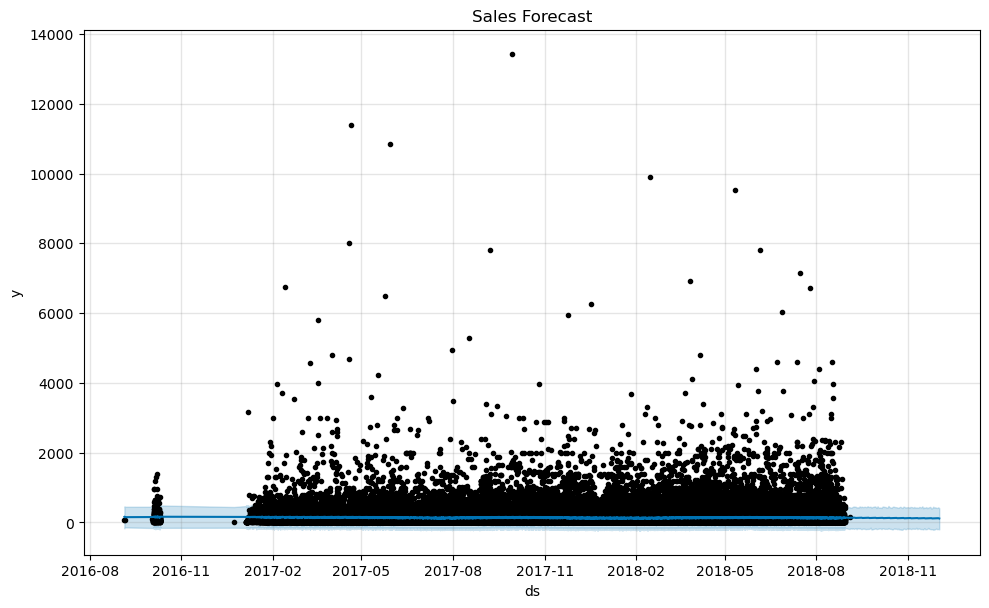

In [5]:
from prophet import Prophet

# Prepare data
forecast_df = merged_df.groupby('order_purchase_timestamp')['price'].sum().reset_index()
forecast_df.columns = ['ds', 'y']

# Train model
model = Prophet()
model.fit(forecast_df)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title('Sales Forecast')
plt.show()

In [11]:
merged_df.to_csv('cleaned_ecommerce_data.csv', index=False)
rfm_df.to_csv('rfm_segments.csv')

## Insights & Business Recommendations


### Insights

1. **Sales spike during holiday months**  
   - Analysis shows highest sales between **November and January**, aligning with holiday shopping behavior.

2. **Top selling categories are Electronics and Fashion**
   - Based on product counts and total revenue, electronics accessories and apparel lead across months.

3. **High delays in large metro areas**
   - Delivery times were longest in cities like São Paulo and Rio, likely due to logistics congestion.

4. **Loyal customers are big spenders**
   - RFM analysis shows customers in the **‘Champions’** segment spend significantly more, mainly on tech products.

5. **Positive correlation between review scores and fast delivery**
   - Customers leaving 4–5 star reviews typically experienced **faster delivery times**.



###  Business Recommendations

1. **Launch targeted promotions during peak seasons**
   - Offer discounts, bundle deals, and limited-time offers around November–January to maximize revenue.

2. **Improve logistics in high-delay zones**
   - Partner with reliable local carriers in top cities to reduce delivery delays and improve customer satisfaction.

3. **Create loyalty reward programs**
   - Provide **exclusive offers** or cashback for ‘Champions’ and ‘Loyal’ customer segments to retain them.

4. **Upsell to Potential customers**
   - Use email campaigns and push notifications to convert **‘Potential’** into **‘Loyal’** customers.

5. **Collect feedback from low-rated deliveries**
   - Contact users with **<3 star reviews** to understand pain points and improve service operations.



In [6]:
forecast.to_csv('sales_forecast.csv', index=False)
